In [1]:
import cv2
import numpy as np
import imageio
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
plt.rcParams["figure.figsize"] = (20,20)

In [101]:
input_dir = '/home/ekaterina/Work/SuperGluePretrainedNetwork/assets/SamplePairsImageRegistration/'

image0_path = 'after_MJ10x_0070_IMG_20191226_144808.jpg'

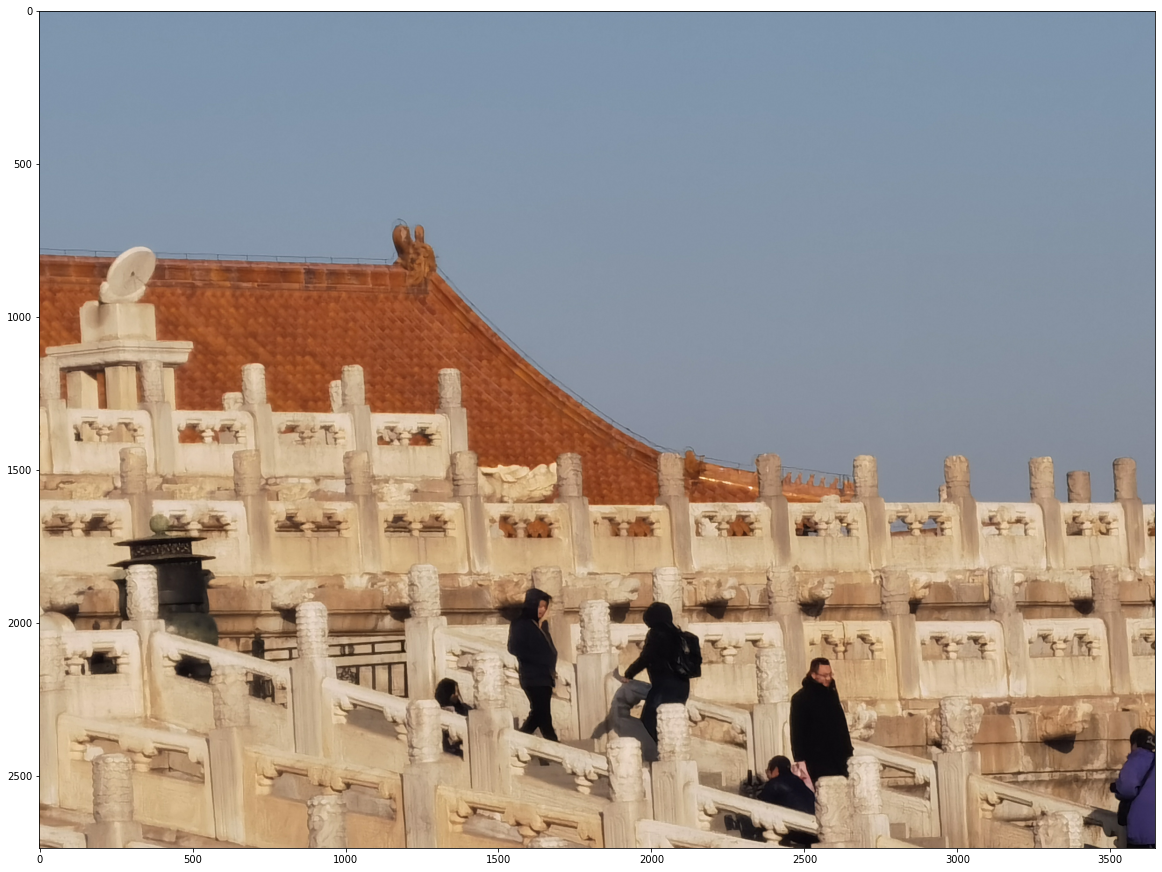

In [102]:
image = imageio.imread(input_dir+image0_path)
plt.imshow(image)

In [114]:
coord_info = np.dstack(np.meshgrid(np.arange(image.shape[1]), np.arange(image.shape[0])))

In [80]:
coord_info.shape

(2736, 3648, 2)

In [77]:
image.shape

(2736, 3648, 3)

In [122]:
new_image = np.dstack((image, coord_info))

In [123]:
new_image = (new_image - new_image.mean(axis=(0, 1))) / (new_image.std(axis=(0, 1)))

In [106]:
new_image[-2:].shape

(2, 3648, 5)

(array([[  0.,   0.,   0., ..., 707., 645.,  10.],
        [  0.,   0.,   0., ..., 713., 642.,   9.],
        [  0.,   0.,   0., ..., 707., 680.,  14.],
        ...,
        [ 51.,  64., 260., ..., 197., 323.,   0.],
        [ 49.,  65., 261., ..., 200., 312.,   0.],
        [ 52.,  63., 261., ..., 182., 325.,   0.]]),
 array([-3.68846371, -3.0888307 , -2.48919769, -1.88956468, -1.28993166,
        -0.69029865, -0.09066564,  0.50896738,  1.10860039,  1.7082334 ,
         2.30786642]),
 <a list of 3648 BarContainer objects>)

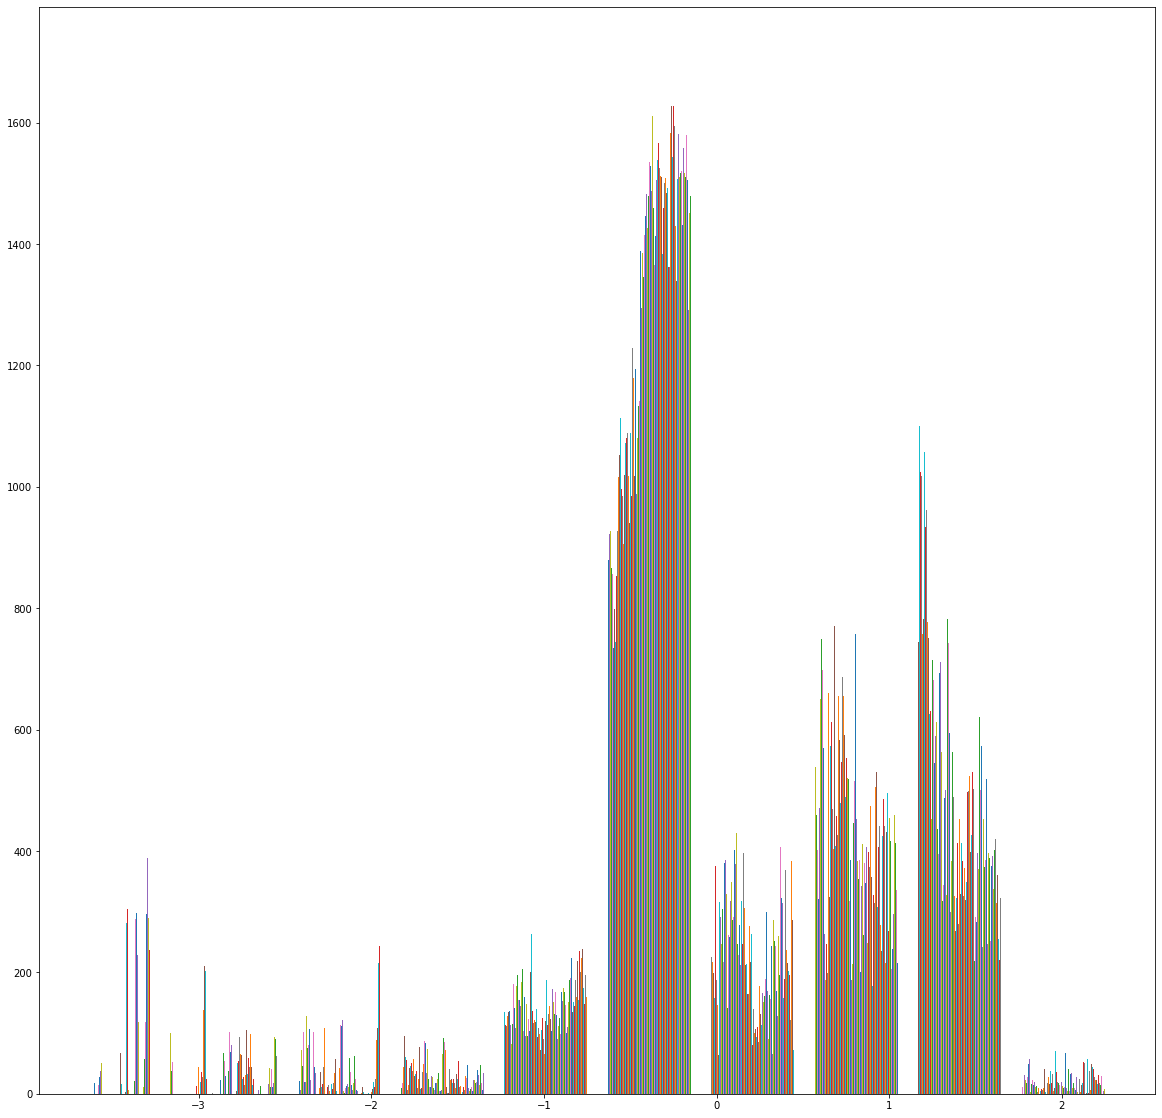

In [99]:
plt.hist(new_image[:, :, 0])

(array([[2736.,    0.,    0., ...,    0.,    0.,    0.],
        [2736.,    0.,    0., ...,    0.,    0.,    0.],
        [2736.,    0.,    0., ...,    0.,    0.,    0.],
        ...,
        [   0.,    0.,    0., ...,    0.,    0., 2736.],
        [   0.,    0.,    0., ...,    0.,    0., 2736.],
        [   0.,    0.,    0., ...,    0.,    0., 2736.]]),
 array([-1.73157608, -1.38526086, -1.03894565, -0.69263043, -0.34631522,
         0.        ,  0.34631522,  0.69263043,  1.03894565,  1.38526086,
         1.73157608]),
 <a list of 3648 BarContainer objects>)

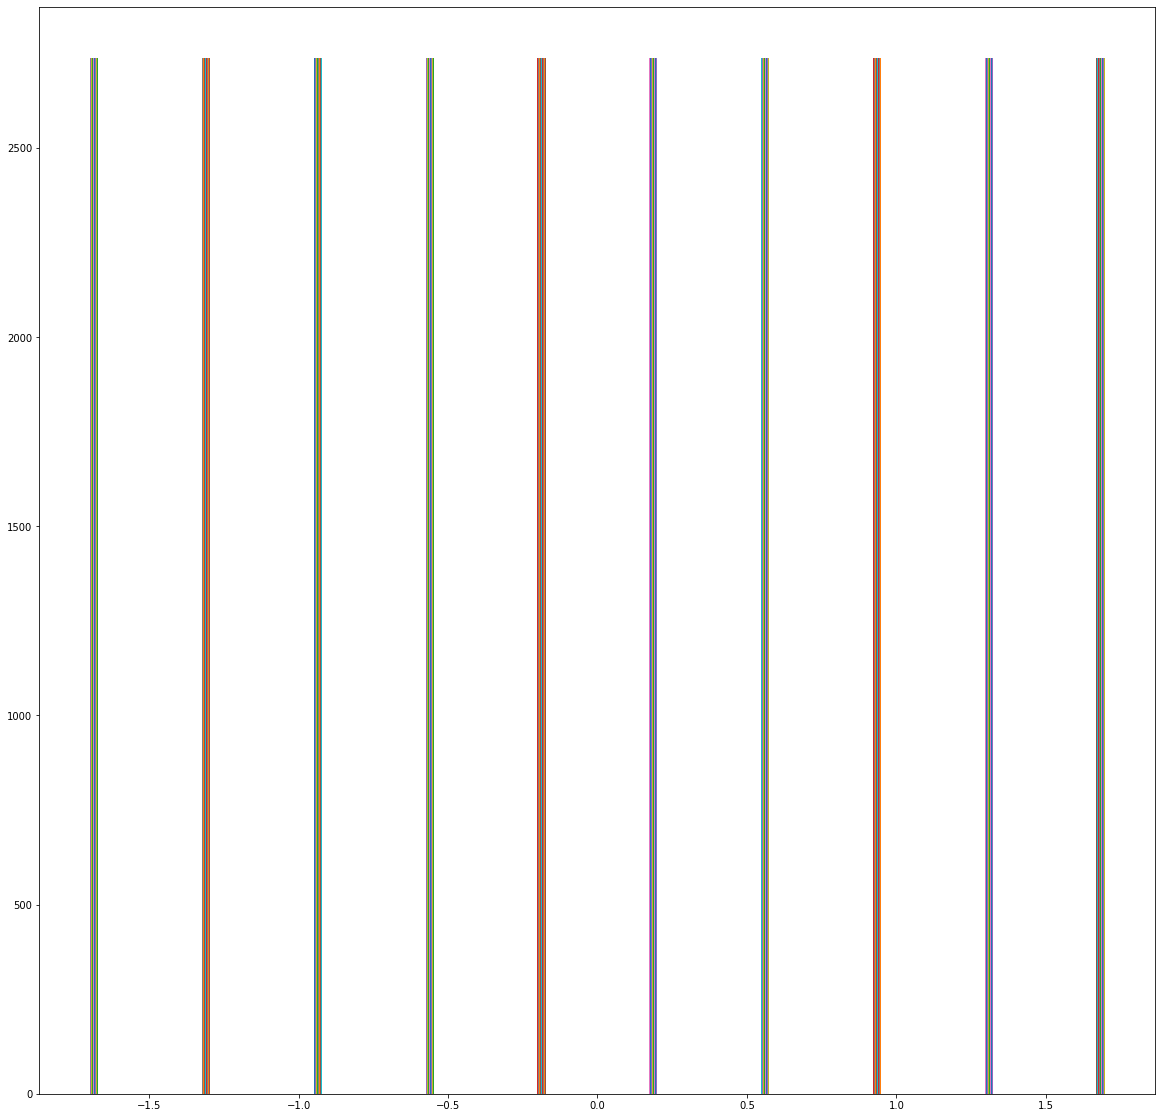

In [100]:
plt.hist(new_image[:, :, 3])

In [137]:
pixel_values = image.reshape((-1, 3))
# convert to float
pixel_values = np.float32(pixel_values)

In [162]:
#criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)

In [163]:
k = 4
_, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

In [164]:
# convert back to 8 bit values
centers = np.uint8(centers)

# flatten the labels array
labels = labels.flatten()

In [165]:
labels

array([0, 0, 0, ..., 2, 2, 2], dtype=int32)

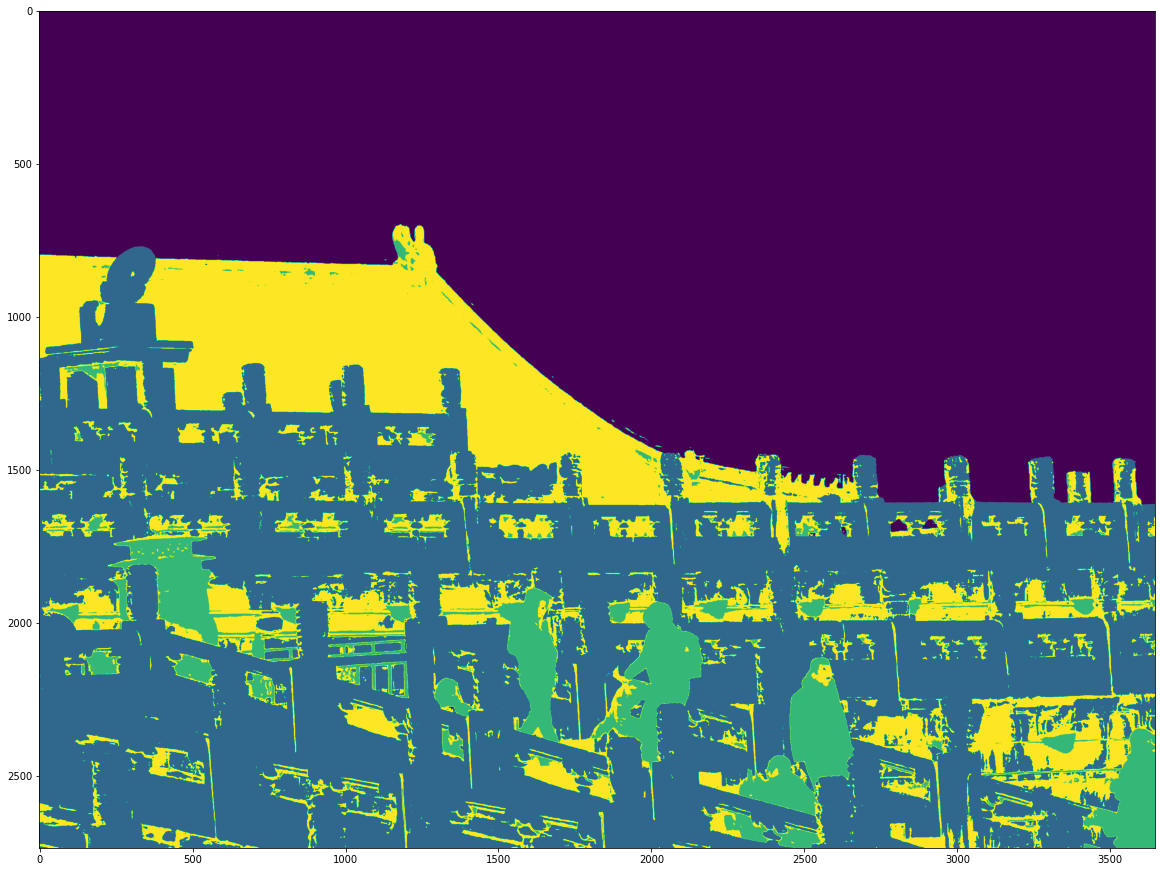

In [166]:
plt.imshow(labels.reshape(2736, 3648))

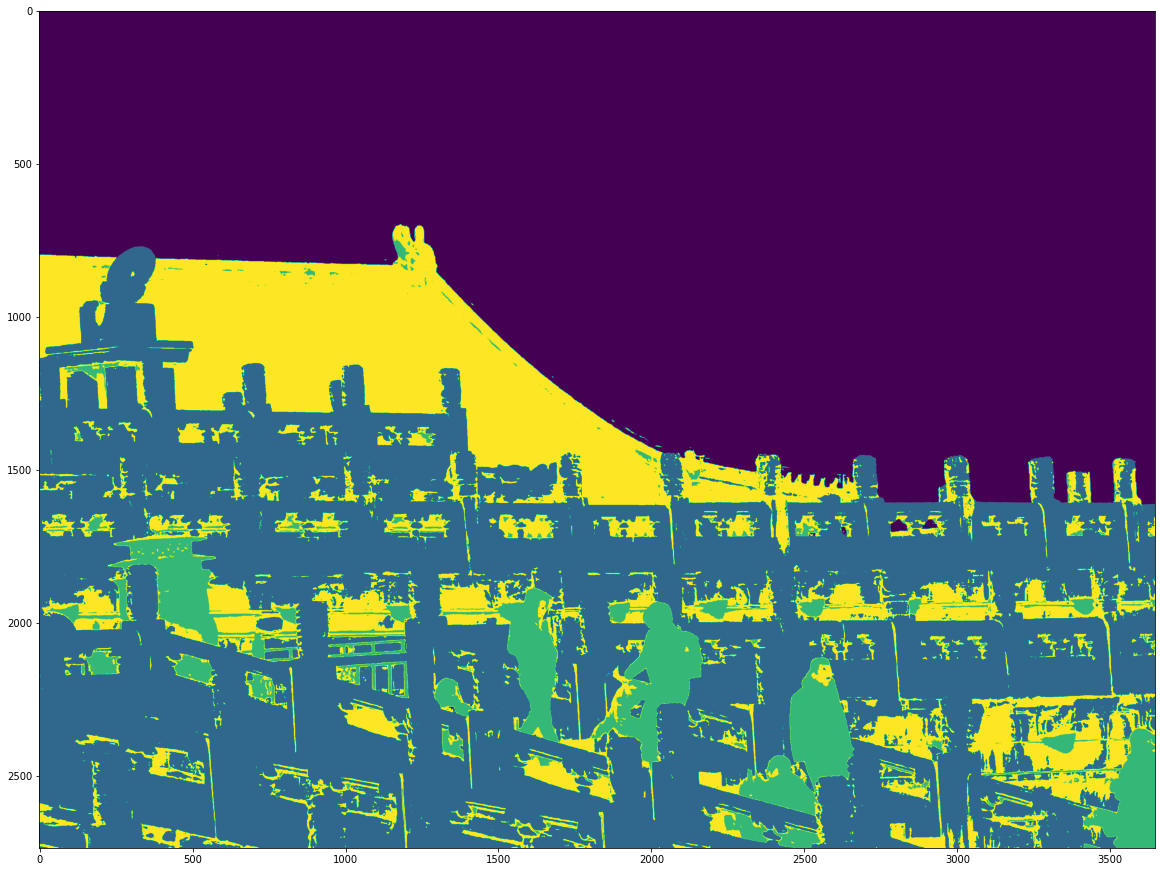

In [167]:
plt.imshow(labels.reshape(2736, 3648))

In [58]:
segmented_image = centers[labels.flatten()]

In [59]:
np.unique(segmented_image)

array([ 31,  34,  46,  64,  96, 127, 142, 148, 166, 175, 202], dtype=uint8)

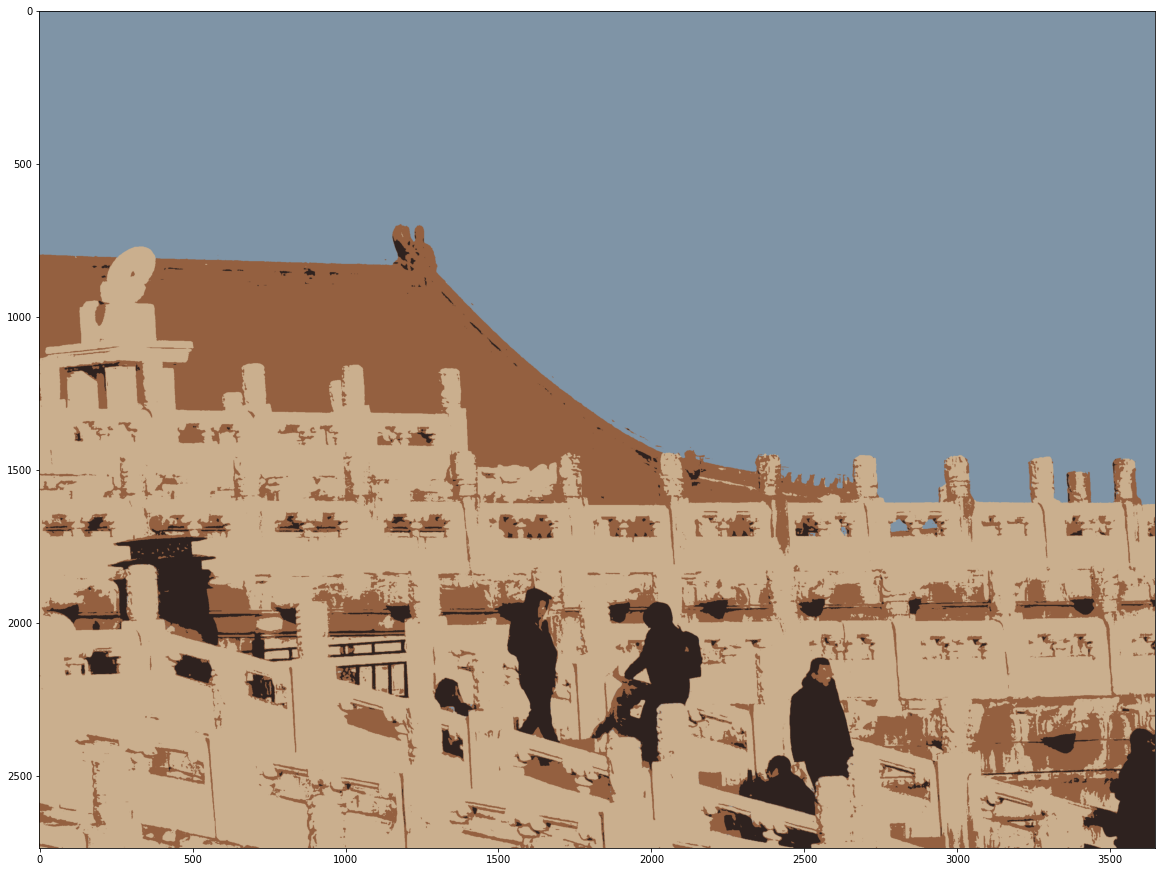

In [60]:
segmented_image = segmented_image.reshape(image.shape)
# show the image
plt.imshow(segmented_image)
plt.show()

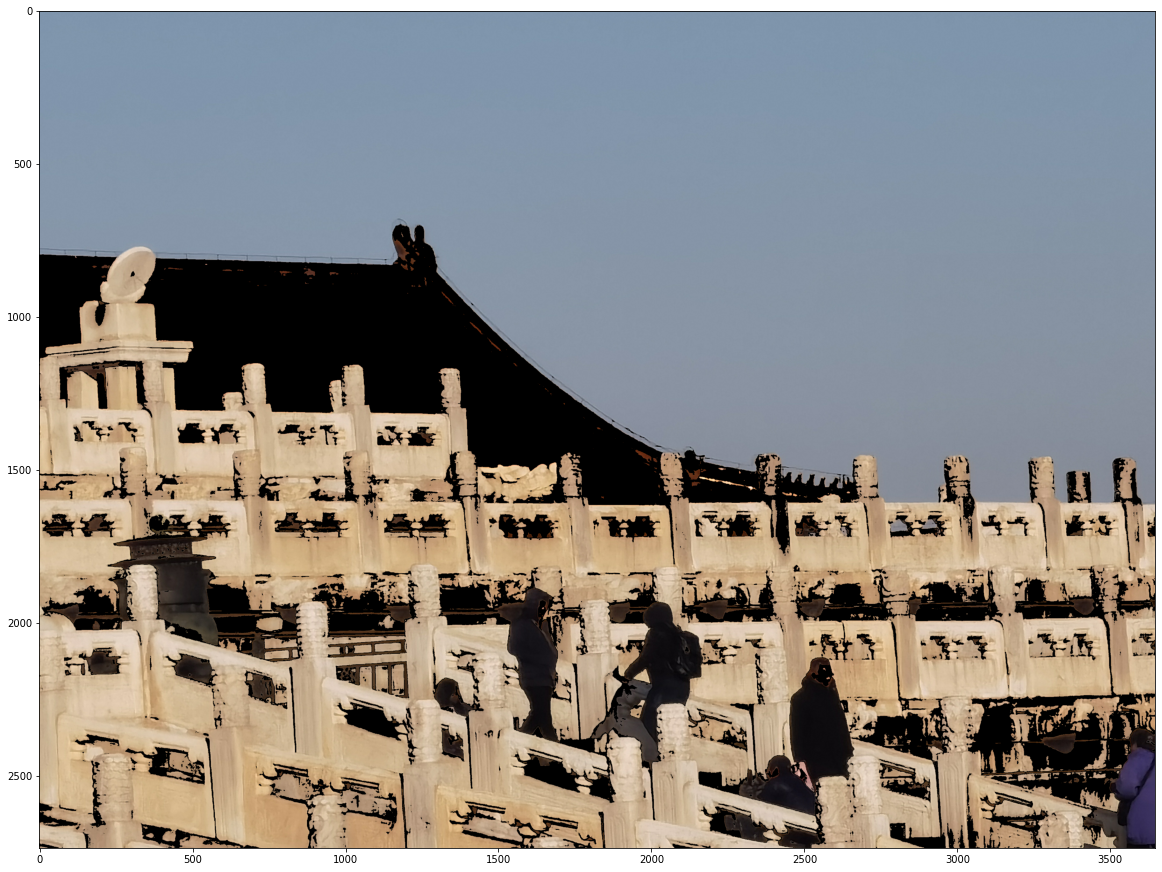

In [61]:
# disable only the cluster number 2 (turn the pixel into black)
masked_image = np.copy(image)
# convert to the shape of a vector of pixel values
masked_image = masked_image.reshape((-1, 3))
# color (i.e cluster) to disable
cluster = 2
masked_image[labels == cluster] = [0, 0, 0]
# convert back to original shape
masked_image = masked_image.reshape(image.shape)
# show the image
plt.imshow(masked_image)
plt.show()


In [169]:
import cv2
import numpy as np
import random
import sys

#class pour une pile
class Stack():
    def __init__(self):
        self.item = []
        self.obj=[]
    def push(self, value):
        self.item.append(value)

    def pop(self):
        return self.item.pop()

    def size(self):
        return len(self.item)

    def isEmpty(self):
        return self.size() == 0

    def clear(self):
        self.item = []

class regionGrow():
  
    def __init__(self,im_path,th):
        self.readImage(im_path)
        self.h, self.w,_ =  self.im.shape
        self.passedBy = np.zeros((self.h,self.w), np.double)
        self.currentRegion = 0
        self.iterations=0
        self.SEGS=np.zeros((self.h,self.w,3), dtype='uint8')
        self.stack = Stack()
        self.thresh=float(th)
    def readImage(self, img_path):
        self.im = cv2.imread(img_path,1)
    

    def getNeighbour(self, x0, y0):
        neighbour = []
        for i in (-1,0,1):
            for j in (-1,0,1):
                if (i,j) == (0,0): 
                    continue
                x = x0+i
                y = y0+j
                if self.limit(x,y):
                    neighbour.append((x,y))
        return neighbour
    def ApplyRegionGrow(self):
        randomseeds=[[self.h/2,self.w/2],
            [self.h/3,self.w/3],[2*self.h/3,self.w/3],[self.h/3-10,self.w/3],
            [self.h/3,2*self.w/3],[2*self.h/3,2*self.w/3],[self.h/3-10,2*self.w/3],
            [self.h/3,self.w-10],[2*self.h/3,self.w-10],[self.h/3-10,self.w-10]
                    ]
        np.random.shuffle(randomseeds)
        for x0 in range (self.h):
            for y0 in range (self.w):
         
                if self.passedBy[x0,y0] == 0 and (int(self.im[x0,y0,0])*int(self.im[x0,y0,1])*int(self.im[x0,y0,2]) > 0) :  
                    self.currentRegion += 1
                    self.passedBy[x0,y0] = self.currentRegion
                    self.stack.push((x0,y0))
                    self.prev_region_count=0
                    while not self.stack.isEmpty():
                        x,y = self.stack.pop()
                        self.BFS(x,y)
                        self.iterations+=1
                    if(self.PassedAll()):
                        break
                    if(self.prev_region_count<8*8):     
                        self.passedBy[self.passedBy==self.currentRegion]=0
                        x0=random.randint(x0-4,x0+4)
                        y0=random.randint(y0-4,y0+4)
                        x0=max(0,x0)
                        y0=max(0,y0)
                        x0=min(x0,self.h-1)
                        y0=min(y0,self.w-1)
                        self.currentRegion-=1

        for i in range(0,self.h):
            for j in range (0,self.w):
                val = self.passedBy[i][j]
                if(val==0):
                    self.SEGS[i][j]=255,255,255
                else:
                    self.SEGS[i][j]=val*35,val*90,val*30
        if(self.iterations>200000):
            print("Max Iterations")
        print("Iterations : "+str(self.iterations))
        plt.imshow(self.SEGS)
        plt.show()

    def BFS(self, x0,y0):
        regionNum = self.passedBy[x0,y0]
        elems=[]
        elems.append((int(self.im[x0,y0,0])+int(self.im[x0,y0,1])+int(self.im[x0,y0,2]))/3)
        var=self.thresh
        neighbours=self.getNeighbour(x0,y0)
        
        for x,y in neighbours:
            if self.passedBy[x,y] == 0 and self.distance(x,y,x0,y0)<var:
                if(self.PassedAll()):
                    break;
                self.passedBy[x,y] = regionNum
                self.stack.push((x,y))
                elems.append((int(self.im[x,y,0])+int(self.im[x,y,1])+int(self.im[x,y,2]))/3)
                var=np.var(elems)
                self.prev_region_count+=1
            var=max(var,self.thresh)
                
    
    
    def PassedAll(self):
   
        return self.iterations>200000 or np.count_nonzero(self.passedBy > 0) == self.w*self.h


    def limit(self, x,y):
        return  0<=x<self.h and 0<=y<self.w
    def distance(self,x,y,x0,y0):
        return ((int(self.im[x,y,0])-int(self.im[x0,y0,0]))**2+(int(self.im[x,y,1])-int(self.im[x0,y0,1]))**2+(int(self.im[x,y,2])-int(self.im[x0,y0,2]))**2)**0.5


exemple = regionGrow(input_dir+image0_path,15)
exemple.ApplyRegionGrow()


KeyboardInterrupt: 

In [200]:
image_exp.shape

(684, 912)

Text(0.5, 1.0, 'histogram of grey values')

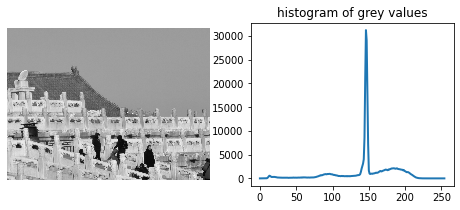

In [201]:
image_exp = cv2.cvtColor(cv2.resize(image,(image.shape[1]//6,image.shape[0]//6)), cv2.COLOR_RGB2GRAY)
hist = np.histogram(image_exp, bins=np.arange(0, 256))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
ax1.imshow(image_exp, cmap=plt.cm.gray, interpolation='nearest')
ax1.axis('off')
ax2.plot(hist[1][:-1], hist[0], lw=2)
ax2.set_title('histogram of grey values')

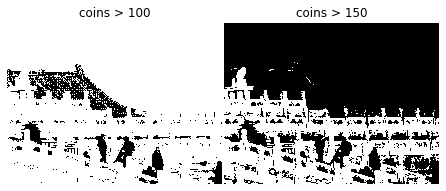

In [202]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3), sharex=True, sharey=True)
ax1.imshow(image_exp > 100, cmap=plt.cm.gray, interpolation='nearest')
ax1.set_title('coins > 100')
ax1.axis('off')

ax2.imshow(image_exp > 150, cmap=plt.cm.gray, interpolation='nearest')
ax2.set_title('coins > 150')
ax2.axis('off')

margins = dict(hspace=0.01, wspace=0.01, top=1, bottom=0, left=0, right=1)
fig.subplots_adjust(**margins)

Text(0.5, 1.0, 'Canny detector')

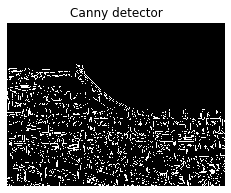

In [203]:
from skimage.feature import canny
edges = canny(image_exp/255.)

fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(edges, cmap=plt.cm.gray, interpolation='nearest')
ax.axis('off')
ax.set_title('Canny detector')

Text(0.5, 1.0, 'Filling the holes')

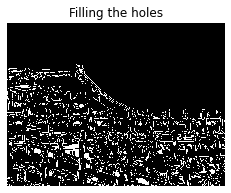

In [204]:
from scipy import ndimage as ndi

fill_coins = ndi.binary_fill_holes(edges)

fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(fill_coins, cmap=plt.cm.gray, interpolation='nearest')
ax.axis('off')
ax.set_title('Filling the holes')

Text(0.5, 1.0, 'Removing small objects')

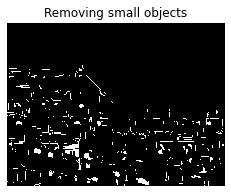

In [205]:
from skimage import morphology
coins_cleaned = morphology.remove_small_objects(fill_coins, 21)

fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(coins_cleaned, cmap=plt.cm.gray, interpolation='nearest')
ax.axis('off')
ax.set_title('Removing small objects')

Text(0.5, 1.0, 'elevation_map')

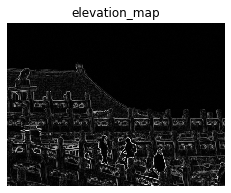

In [206]:
from skimage.filters import sobel

elevation_map = sobel(image_exp)

fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(elevation_map, cmap=plt.cm.gray, interpolation='nearest')
ax.axis('off')
ax.set_title('elevation_map')

Text(0.5, 1.0, 'markers')

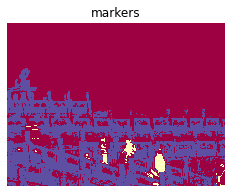

In [212]:
markers = np.zeros_like(image_exp)
markers[image_exp < 20] = 1
markers[image_exp > 160] = 2

fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(markers, cmap=plt.cm.get_cmap("Spectral"), interpolation='nearest')
ax.axis('off')
ax.set_title('markers')

/home/ekaterina/Work/environments/myvenv1/lib/python3.7/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


Text(0.5, 1.0, 'segmentation')

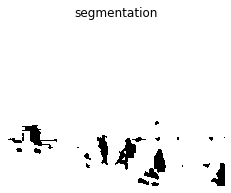

In [208]:
segmentation = morphology.watershed(elevation_map, markers)

fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(segmentation, cmap=plt.cm.gray, interpolation='nearest')
ax.axis('off')
ax.set_title('segmentation')

/home/ekaterina/Work/environments/myvenv1/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  """


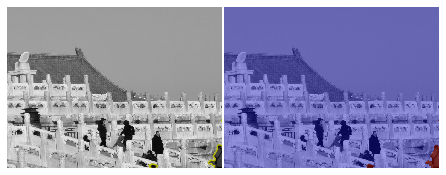

In [209]:
from skimage.color import label2rgb

segmentation = ndi.binary_fill_holes(segmentation - 1)
labeled_coins, _ = ndi.label(segmentation)
image_label_overlay = label2rgb(labeled_coins, image=image_exp)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3), sharex=True, sharey=True)
ax1.imshow(image_exp, cmap=plt.cm.gray, interpolation='nearest')
ax1.contour(segmentation, [0.5], linewidths=1.2, colors='y')
ax1.axis('off')

ax2.imshow(image_label_overlay, interpolation='nearest')
ax2.axis('off')


fig.subplots_adjust(**margins)

In [233]:
import numpy as np
from scipy import signal
import matplotlib.image as mpimg
import skimage
 
def gaussian_kernel(k, s = 0.5):
    # generate a (2k+1)x(2k+1) gaussian kernel with mean=0 and sigma = s
    probs = [np.exp(-z*z/(2*s*s))/np.sqrt(2*np.pi*s*s) for z in range(-k,k+1)]
    return np.outer(probs, probs)
 
def create_graph(imfile, k=1., sigma=0.8, sz=1):
    # create the pixel graph with edge weights as dissimilarities
    rgb = imageio.imread(imfile).copy()[:,:,:3]
    gauss_kernel = gaussian_kernel(sz, sigma)
    for i in range(3):
        rgb[:,:,i] = signal.convolve2d(rgb[:,:,i], gauss_kernel, boundary='symm', mode='same')
    yuv = skimage.color.rgb2yiq(rgb)
    (w, h) = yuv.shape[:2]
    edges = {}
    for i in range(yuv.shape[0]):
        for j in range(yuv.shape[1]):
            #compute edge weight for nbd pixel nodes for the node i,j
            for i1 in range(i-1, i+2):
                for j1 in range(j-1, j+2):
                    if i1 == i and j1 == j: continue
                        
                    if i1 >= 0 and i1 == 0 and j1 < h:
                        wt = np.abs(yuv[i,j,0]-yuv[i1,j1,0])
                        n1, n2 = ij2id(i,j,w,h), ij2id(i1,j1,w,h)
                        edges[n1, n2] = edges[n2, n1] = wt
                        
    return edges

In [234]:
result = create_graph(input_dir+image0_path)

AttributeError: module 'skimage.color' has no attribute 'ij2id'